# PA3

In this assignment, you will perform logistic regression on the MNIST dataset to detect which number is written in an image! Each image in the MNIST data shows a handwritten number, and your goal is to use logistic regression to detect when a number is an "8" or a "1".

Each input example ($x_i$ from class) is a vector referring to the brightness of each pixel in an image. Your logistic regression will learn a weight vector whose length is equal to the number of pixels in each image.

First, you will train logistic regression to recognize the digit 8. You'll do this once with coordinate descent (CD) and once with SGD (discussed in class). Then, you'll train logistic regression to recognize the digit 1, using your preferred method between CD and SGD.

Fill in the ACT's below. Writing asserts to test your code is recommended, but not graded for this assignment.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import randint
from numpy.random import permutation

In [2]:
np.random.seed = 10

In [3]:
# Install Tensorflow before calling the following line (for anaconda, run "conda install tensorflow")
# (for a native Python installation, you can try pip or pip3 install tensorflow)

# Import the MNIST data
from tensorflow.keras.datasets import mnist as keras_mnist
(X_train, y_train), (X_test, y_test) = keras_mnist.load_data()

/Users/arpj/anaconda3/envs/cos324/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/arpj/anaconda3/envs/cos324/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/arpj/anaconda3/envs/cos324/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/arpj/anaconda3/envs/cos324/lib/python3.7/s

In [4]:
# There are 60000 training examples, each example is a 28 by 28 pixel
#   grayscale image, represented by a 28 by 28 array of numbers
print('Shape of X_train: ', X_train.shape)

Shape of X_train:  (60000, 28, 28)


## Log-Loss and Its Gradient

In lecture, we used the convention that negative examples are labeled $-1$ and positive examples are labeled $+1$. That is, $y_i\in\{-1,+1\}$. We found that, if $\mathcal{L}(\mathbf{w})$ is our loss on $\mathbf{w}$, and $|S|$ is the number of examples,
$$\mathcal{L}(\mathbf{w}) = \frac{1}{|S|} \sum_{i\in S} \log\big(1+e^{-z_i}\big)
~~ \mbox{ where } ~~
z_i = y_i (\mathbf{w} \cdot \mathbf{x}_i) ~~ .$$
This occurs when we let $\mathcal{L}(\mathbf{w})$ be the negative log probability of us predicting the right label. Note: Sometimes, in lecture we used $\mathcal{L}(\mathbf{w}) = \sum_{i\in S} \log(1+e^{-z_i})$, omitting the division by $|S|$. Since we generally assume that the number of examples $|S|$ is fixed, these two forms of the loss differ by a constant factor, so they are pretty much equivalent.

Alternatively, suppose we use a different convention, that negative examples are labeled $0$ instead. That is, $y_i\in\{0,1\}$. Just as in the previous case, we predict $+1$ with probability $\hat{y}_i = 1/(1+e^{-\mathbf{w} \cdot \mathbf{x_i}})$. Thus, we predict $0$ with probability $1 - \hat{y}_i = 1 - 1/(1+e^{-\mathbf{w} \cdot \mathbf{x_i}}) = 1/(1+e^{\mathbf{w} \cdot \mathbf{x_i}})$.

Then, observe that the probability of predicting the right label is equal to $\hat{y}_i$ when $y_i = 1$, and is equal to $1 - \hat{y}_i$ when $y_i = 0$. Then, do you see why the loss can be expressed as the following? (You can plug in $y_i = 1$ or $y_i = 0$.)
$$\mathcal{L}(\mathbf{w}) =
  -\frac{1}{|S|} \sum_{i\in S} \big(y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i)\big)
~~ \mbox{ where } ~~ 
\hat{y}_i = \frac{1}{1+e^{-\mathbf{w} \cdot \mathbf{x_i}}}
~~.$$

If we find the gradient for the first form (when $y_i\in\{-1,+1\}$), we obtain the following:
$$ \nabla_{\mathbf{w}} \mathcal{L} = -\frac{1}{|S|} \sum_{i\in S} q_i y_i \mathbf{x}_i 
~~ \mbox{ where } ~~ q_i = \frac{1}{1 + e^{z_i}} ~~ .
$$

For the second form (when $y_i\in\{0,+1\}$), we find that the gradient is:
$$ \nabla_{\mathbf{w}} \mathcal{L} = \frac{1}{|S|} \sum_{i\in S} \big(\hat{y}_i - y_i\big) \mathbf{x}_i  ~~ ,$$
where $\hat{y}_i$ is as defined above. You can verify these gradient values for yourself.

For your own practice (ungraded), you should confirm the equivalence of these two forms, and derive them for yourself. That is, calculate both gradients (see if you get the same thing we did). Then, verify that when you plug in $y_i = 1$ you get the same thing, and when you plug in $y_i = -1$ or $=0$ respectively, you get the same thing. If you're having trouble with this, please ask on Piazza!

Finally, implement the following functions for the case where $y_i\in\{-1,+1\}$. You will use these functions throughout this notebook.

In [5]:
# utility function for z
def compute_z(X, y, w):
    return y * (np.dot(X, w))


# Calculate loss from margins
# Here, z is equal to y times X dot w
# That is, z_i = y_i * x_i dot w
def logloss_from_z(z):
    ### ACT 1
    return np.mean(np.log(1 + np.power(np.e, -z)))  # mean over what axis?


# Calculate error from margins
# the error is the proportion of examples that you "get wrong".
# a.k.a. the examples where you assign less than 50% chance to the correct label
# This is equivalent to the proportion of examples where z_i is less than 0
def error_from_z(z):
    ### ACT 2
    wrong = z[z <= 0]
    return wrong.size / z.size


# Calculate loss from parameter vector
def logloss(X, y, w):
    ### ACT 3
    z = compute_z(X, y, w)
    return logloss_from_z(z)


# Calculate error from parameter vector
def error(X, y, w):
    ### ACT 4
    z = compute_z(X, y, w)
    return error_from_z(z)


# Gradient of LogLoss w.r.t. w
def logloss_gradient(X, y, w, reshape=False, verbose=False):
    ### ACT 5
    """
    you should return an np.array for this act. 
    In particular, the output should be a vector or 1-D array of length equal to the length of w. 
    This is because each entry in the gradient is referring to 
    the partial derivative with respect to the corresponding coordinate of w.
    """
    # mean over which axis? is the result of a gradient a matrix, a vector, a scalar?
    z = compute_z(X, y, w)
    q = 1 / (1 + np.power(np.e, z))
    grad = -1 * np.mean(q * y * X, axis=0)
    
    if reshape:
        grad = grad.reshape((-1, 1))
    
    if verbose:
        print('X shape', X.shape)
        print('y shape', y.shape)
        print('z shape', z.shape)
        print('q shape', q.shape)
        print('grad shape', grad.shape)
    return grad


# Calculate error & loss from parameter vector
# Return two floats in the format (loss, error)
def logloss_and_error(X, y, w):
    ### ACT 6
    return logloss(X, y, w), error(X, y, w)

## Bias

Normally, we initialize $w$ to be zero (as we discussed in the last assignment). This means we initially predict everything as 0.5 (a.k.a. 50-50). This might not make sense. For example, in the MNIST problem, we are distinguishing a single digit from the 9 other digits. On average, there's only a 10% chance each image is our desired digit, so initially maybe we should predict something lower.

This is where bias comes in. Bias is something that is added to every prediction. For example, if we have bias $b$, an example $x_i$, and a weight vector $\mathbf{w}$, we would predict the following probability:
$$\Pr[y_i = +1] = \frac{1}{1 + e^{-(\mathbf{w}\cdot \mathbf{x}_i + b)}}$$

So, in MNIST, we'd want to initialize bias to be negative, since initially we would predict that an average digit should have less than 50% chance to be classified as $+1$.

Bias is actually easy to add into our models.

Rather than creating a new variable $b$, we simply append $1$ to each example $\mathbf{x}_i$. (That is, we append a column of ones to the data matrix $X$.) Since the length of $\mathbf{x}_i$ has increased by one, the length of our weight vector $\mathbf{w}$ has also increased by one. Let's call the final entry of our weight vector $w_d$, and call the final entry of our example $x_{i, d}$ (so $x_{i, d} = 1$). Then, when we compute $\mathbf{w}\cdot \mathbf{x}_i$, we get
$$\mathbf{w} \cdot \mathbf{x}_i = w_1x_{i, 1} + w_2x_{i, 2} + \ldots + w_dx_{i, d}$$
which equals the previous dot product, plus $w_dx_{i, d}$ which equals $w_d$.

Thus, $w_{d}$ becomes the bias term: it is added to every dot product regardless of the example $\mathbf{x}_i$.

## Setting Initial Bias Using Log-Odds (ACT's 7-9)
As mentioned above, we don't necessarily want to initialize the bias term of $w$, $w_{d}$, to zero. Below is a small math exercise where you will find the best value to initialize bias.

Total number of positive examples is $n_+$ (pos) and negative $n_-$ (neg). Assume $\mathbf{w}=\mathbf{0}$ except for the weight of the last feature $w_{d}$. Since we have the other entries of $w$ initialized equal to $0$, we can write the logistic loss as the following:
$$\frac1n \sum_{i:y_i=+1} \log(1+\exp(-w_d)) + \frac1n \sum_{i:y_i=-1} \log(1+\exp(w_d))$$
If you're unclear on how we got this, verify it by plugging in $\mathbf{w}$ into the formula for logistic loss. Most of the terms in the dot product equal zero except for the last term in the dot product. For reference: $\exp(-w_d) = e^{-w_d}$.

To find the best initialization for $w_d$, we take the derivative of the above loss, and set it to $0$. The ACT's below ask you to do this, to find the best initial bias. Submit your answer as a LaTeX'd answer within this notebook cell (or make a new notebook cell).

ACT 7: Take the derivative, with respect to $w_{d}$, of the above expression for logistic loss.

ACT 8: Set the derivative of this to zero, and solve for w_d.

ACT 9: Fill in the value of $w_d$ below which minimizes your initial loss, then code it below. (We've given you a hint, the answer is a log of something.)
$$
w_d = \log\left( \mathbf{\mbox{ACT 9}} \right) ~.
$$

In [6]:
# Calculate the initial bias
def init_bias(pos, neg):
   ### ACT 9 continued
    return np.log(pos / neg)

## Image normalization and flattening

Before working with MNIST, we need to normalize and flatten the input images. After all, we do not normally perform logistic regression on 2D input data like images, we normally perform logistic regression on 1D data! So, we first flatten the image so it becomes 1-dimensional.

First we flatten the data set of images: each $p_x \times p_y$ image becomes a 1d vector of size $d = p_x \, p_y$.

This amounts to reshaping $X$ from a $n \times p_x \times p_y$ tensor to a $n \times d$ matrix.

In [7]:
def flatten_images(X):
    ### ACT 10
    n, px, py = X.shape
    images = X.reshape(n, px * py)
    return images

Next, we want to normalize each image. This is useful because some images may be overall darker or lighter, or higher- or lower-contrast than others. We don't want this to affect our classification. Thus, we normalize each image by making sure each image's average "brightness" (a.k.a. pixel value) is 0, and each image's pixels have standard deviation one.

Finally, we want to provide the option to append a bias column of ones to the data matrix.

In your method below, normalize each image, by subtracting the average value of that image over all its pixels, and
dividing by the standard deviation of the image's pixel values. If the bias argument is non-zero, add a bias term by appending `bias` to each example. For example, if `bias=1`, then append an entry of $1$ to each example. Algebraicly, flattening and normalizing amounts to flattening each image to a $d$ dimensional vector
$\mathbf{x}$ and calculating average pixel value and variance of pixel values,
$$ m = \mathbb{E}(\mathbf{x}) = \frac 1 d \sum_{i=1}^d x_i ~~~
   s^2 = \mathbb{V}(\mathbf{x}) = \frac 1 d \sum_{i=1}^d x_i^2 - m^2 ~~ . $$
Here, $m$ is the image's mean and $s$ is the image's standard deviation. (You can use pre-existing numpy functions to compute these.)

Define $a=s^{-1}$, then the normalized image (represented as a vector) is, ${a (\mathbf{x} - m)}$.

In [8]:
# Normalize each example as described above. If bias is non-zero, add a bias term by appending `bias` to
# each example
def normalize(X, bias=0):
    ### ACT 11
    mean = np.mean(X, axis=1, dtype=np.float64).reshape((-1, 1))  # check axis, if 0 or 1. seems like 1
    std = np.std(X, axis=1, dtype=np.float64).reshape((-1, 1))
    X = (X - mean) / std
    if not bias:
        return X
    n, d = X.shape
    return np.hstack((X, np.ones((n, 1), dtype=np.float64)))

In [9]:
# Normalize and flatten the training and test images
# You may print Xtr and Xte, or view their shape, to get a feeling for their structure
Xtr = normalize(flatten_images(X_train), bias=1)
Xte = normalize(flatten_images(X_test), bias=1)

Convert the train labels $\mathbf{y}^{\mbox{tr}}$ and test labels $\mathbf{y}^{\mbox{te}}$ to vectors over
$\{-1,+1\}$ indicating whether each example is an 8.

For example, `ytr8[i] = -1` if the i-th example is NOT an 8

Similarly to above, viewing the first few entries of ytr8,
may give you some intuition about their contents and structure

In [10]:
ytr8 = (2 * (y_train == 8) - 1).reshape(len(y_train), 1)
yte8 = (2 * (y_test == 8) - 1).reshape(len(y_test), 1)

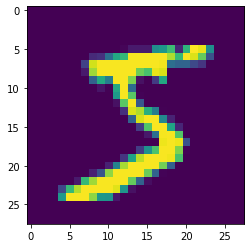

In [11]:
# view sample
example = Xtr[:1,:-1]
plt.imshow(example.reshape(28, 28))

ACT 12: For coordinate descent use the mean value theorem to form a quadratic upper-bound on the loss for a single coordinate $j$. When using the convention of $y_i\in\{0,1\}$ show that,
    $$
     |S|\cdot\mathcal{L}(\mathbf{w}+\delta\mathbf{1}_j) \leq
       \kappa + \sum_i (\hat{y}_i - y_i) X_{ij} \, \delta + \frac18 \sum_i  X_{ij}^2 \, \delta^2 ~~.
    $$
Here we use $\mathbf{w}+\delta\mathbf{1}_j$ to denote $\mathbf{w}$ plus $\delta$ in the $j$-th coordinate. Hint: The slides titled "Mean Value Theorem" and "Putting It All Together" in the Logistic Regression lecture should be helpful. Please ask on Piazza if you're having trouble understanding ACT 12 or the relevant lecture slides!

Note: The factor of $|S|$ multiplied on the left side is used to make this equation similar to the one proved in lecture. In this notebook we divided error and loss by $|S|$ to get average error or loss. However, in the logistic regression lecture we tried to minimize total loss (a.k.a. we didn't divide loss by $|S|$). Minimizing these two losses _is equivalent_ since $|S|$ is just a constant factor, so we multiply by $|S|$ on the left to keep things consistent with lecture in this ACT.

ACT 13: Denote the $j^{\mbox{th}}$ column of $X$ by $\mathbf{v}_j$ and let $c_j= \|\mathbf{v}_j\|^2$.

Show that the $\delta^\star$ minimizing the above bound $\kappa + \sum_i (\hat{y}_i - y_i) X_{ij} \, \delta + \frac18 \sum_i  X_{ij}^2 \, \delta^2$ is,
$$
\delta^\star = \frac{4}{c_j} (\mathbf{y - \hat{y}) \cdot v_j} = \frac{4}{c_j} \sum_{i=1}^n (y_i - \hat{y}_i)\mathbf{v}_j[i] ~~.
$$

(Note that $\mathbf{v}_j[i] = X_{ij}$.) Hint: Take the derivative and set it equal to zero.

ACT 14: Of course the above expression assumes that $y_i\in \{0, 1\}$, which is different from our current setting, where $y_i \in \{-1, 1\}$.

To convert back to the $\{-1, 1\}$ setting, consider the positive and negative examples in the above summation. Positive examples have $y_i = 1$, so that term in the summation becomes $(1 - \hat{y}_i)\mathbf{v}_j[i]$. Negative examples have $y_i = 0$, so that term in the summation becomes $(-\hat{y}_i)\mathbf{v}_j[i]$.

Can you rewrite the expression for $\delta^\star$ when $y_i\in\{-1, 1\}$?

Hint: First, re-write $(y_i - \hat{y}_i)$ from the previous setting in terms of the new $y_i$ and $z_i$, or $y_i$ and $q_i$. You should get a simple expression that replaces $(y_i - \hat{y}_i)$. The other terms in the expression for $\delta^\star$ shouldn't change, since they don't depend on $y_i$. Thus, you can just plug in your new expression for $(y_i - \hat{y}_i)$ into the previous expression for $\delta^\star$.

In [12]:
# `x` is the j-th column of X (a.k.a. the v_j from above)
# `y` is the vector of labels
# `z` is a vector with entries z_i
# `cj` is c_j from above, the squared norm of `x`
def delta_wj(x, y, z, cj):
    ### ACT 15 (code your result from ACT 14 here)
    q = 1 / (1 + np.power(np.e, z))
    # return (4 / cj) * q * y @ x.T 
    return (4 / cj) * np.sum(q * y * x)

In [13]:
# You don't need to use this class yourself: we provided the index-sampling code for you
# sample new index (with or without replacement)
# d is the max index
class IndexSampler:
    def __init__(self, d):
        self.d = d
        self.prm = None
    
    def sample_new_index(self, replace = 1):
        if replace:
            return randint(self.d)
        if self.prm is None:
            self.prm = permutation(self.d)
            self.head = 0
        ind = self.prm[self.head]
        self.head += 1
        if self.head == self.d:
            self.head = 0
            self.prm = None
        return ind

In [14]:
def initialize(X, y, verbose=False):
    ### initialize w, z, c, errors, and losses
    ### c is a vector whose j-th entry is equal to c_j from above
    ### errors should be a vector containing the error at each step
    ### losses should be a vector containing the loss at each step
    ### NOTE: Don't forget to initialize the last entry of w as initial bias!
    n, d = X.shape

    w = np.zeros((d, 1))
    pos = y[y > 0].size
    neg = y[y < 0].size
    
    w_d = init_bias(pos, neg)
    np.append(w, w_d)
    
    z = compute_z(X, y, w)

    c = np.square(np.linalg.norm(X, axis=0)).reshape((1, -1))  # or (-1, 1) 
    
    if verbose:
        print('n, d', n, d)
        print('pos', 'neg', pos, neg)
        print('wd', w_d)
        print('w shape', w.shape)
        print(z.shape)
        print(c.shape)

    return w, z, c

w, z, c = initialize(Xtr, ytr8)

In [15]:
def termination_check(loss_p, loss_c, eps):
    relative_loss = (loss_p - loss_c) / loss_c
    msg = '***Termination condition was met: {0} <= {1}***'
    
    if relative_loss <= eps:
        print(msg.format(relative_loss, eps))
        return True
    return False

In [16]:
# epochs is maximum number of epochs to train
# eps is your termination condition number, similar to in PA2's linear regression
# Every epoch, report the loss (we've provided some code that reports loss for you)
# (An epoch consists of d updates)

### ACT 16
def logistic_regression_cd(X, y, epochs=100, eps=0.001, verbose=False):
    pstr = 'Epoch: {0:2d}  Loss: {1:5.3f}  Error: {2:5.3f}%'
    
    # initialize w, z, c, errors, and losses
    w, z, c = initialize(X, y)
    loss, error = logloss_and_error(X, y, w)
    losses = [loss]
    errors = [error]

    # instantiate samples
    n, d = X.shape
    sampler = IndexSampler(d)

    # start training
    print('*** Logistic Regression CD Began ***\n')
    cur_epoch = 0
    for e in range(1, d * epochs + 1):        
        # we've chosen a coordinate for you, now perform coordinate descent below
        j = sampler.sample_new_index(replace=False)
        
        # cd
        xj = X[:,j].reshape((-1, 1))
        cj = c[:,j]
        z = compute_z(X, y, w)
        a = delta_wj(xj, y, z, cj)

        # update wj
        w[j] += a
        
        if verbose: 
            print('j', j)
            print('c shape', c.shape)
            print('xj shape', xj.shape)
            print('a shape', a.shape)

        if e % d == 0:
            # compute losses and error per epoch
            loss, error = logloss_and_error(X, y, w)

            # update losses and errors with the current loss and error
            losses.append(loss)
            errors.append(error)

            cur_epoch += 1
            print(pstr.format(cur_epoch, losses[-1], errors[-1] * 100))
            if termination_check(losses[-2], losses[-1], eps):
                break
    print('\n')
    return w, losses, errors


In [18]:
start = time.time()
[w, loss, err] = logistic_regression_cd(Xtr, ytr8, epochs=20, verbose=False)  # 20
print('*** Elapsed time: {} minutes ***'.format(round(((time.time() - start) / 60.0), 2)))

*** Logistic Regression CD Began ***

Epoch:  1  Loss: 0.180  Error: 6.350%
Epoch:  2  Loss: 0.166  Error: 5.737%
Epoch:  3  Loss: 0.160  Error: 5.498%
Epoch:  4  Loss: 0.157  Error: 5.377%
Epoch:  5  Loss: 0.155  Error: 5.265%
Epoch:  6  Loss: 0.153  Error: 5.212%
Epoch:  7  Loss: 0.151  Error: 5.180%
Epoch:  8  Loss: 0.150  Error: 5.138%
Epoch:  9  Loss: 0.149  Error: 5.108%
Epoch: 10  Loss: 0.149  Error: 5.097%
Epoch: 11  Loss: 0.148  Error: 5.068%
Epoch: 12  Loss: 0.147  Error: 5.040%
Epoch: 13  Loss: 0.147  Error: 5.017%
Epoch: 14  Loss: 0.146  Error: 5.005%
Epoch: 15  Loss: 0.146  Error: 4.983%
Epoch: 16  Loss: 0.145  Error: 4.945%
Epoch: 17  Loss: 0.145  Error: 4.932%
Epoch: 18  Loss: 0.144  Error: 4.917%
Epoch: 19  Loss: 0.144  Error: 4.905%
Epoch: 20  Loss: 0.143  Error: 4.897%


*** Elapsed time: 8.02 minutes ***


In [19]:
def plotter(fname, data_list, lnames):
    for data in data_list:
        plt.plot(range(1, 1 + len(data)), data, linewidth=2, linestyle='-', marker='o')
        
    plt.legend(tuple(lnames))
    
    xt = np.arange(1, 1 + max([len(data) for data in data_list]))
    plt.xticks(xt)

    plt.grid()    
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel(fname, fontsize=14)
    plt.show()

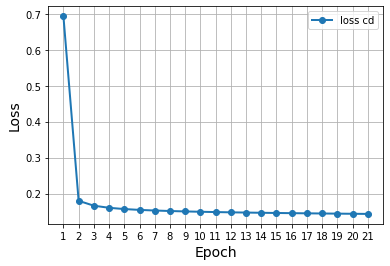

In [20]:
# plot the loss of your logistic classifier over time
# The y-axis should be loss, and the x-axis should be the epoch
# The plot doesn't need to be pretty, just show the loss going down over time!
### ACT 17
# trend_plotter(loss, 'Loss')
plotter('Loss', [loss], ['loss cd'])

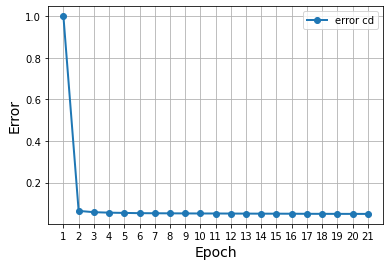

In [21]:
# plot the error of your logistic classifier over time 
### ACT 18
plotter('Error', [err], ['error cd'])

In [26]:
pstr = 'Test  Loss: {0:5.3f}  Error: {1:5.3f} %'

In [27]:
# Evaluate the loss and error of your weight vector on the test data and test labels
# (Don't update your weight vector here: this is purely to evaluate it)
### ACT 19
test_loss, test_err = logloss_and_error(Xte, yte8, w)

In [28]:
print(pstr.format(test_loss, test_err * 100))

Test  Loss: 0.143  Error: 5.240 %


In [31]:
# Here, we visualize w for you
# First, we bound the entries of w within 3 standard deviations
# (in order to ignore outliers which would mess up the image)
# image_w = w
image_w = np.maximum(np.minimum(w, 3 * np.std(w)), -3 * np.std(w))
# Next, we re-shape image_w into the original 28 by 28 shape of the image
image_w = image_w[0:-1].reshape(28, 28)

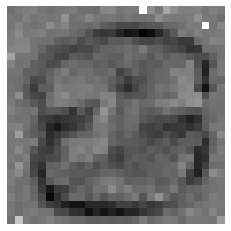

In [32]:
# Visualize image_w
plt.axis('off')
plt.imshow(image_w, cmap='gray')

In [33]:
# `ind` is the indices in Xtest of images which are "8" but classified incorrectly
#   by your classifier
ind = (np.argwhere(((yte8 == 1) * (np.matmul(Xte, w) < 0))))[:,0]
ind.shape

(343,)

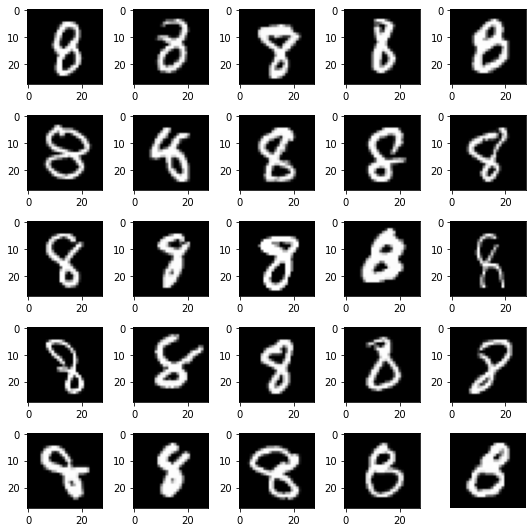

In [34]:
# Display 25 images of "8"s which your classifier incorrectly classified as non-8
# This kind of visualization can be useful if you're wondering what sorts of images give
#   your classifier trouble
ncols, nrows = 5, 5
fig, axes = plt.subplots(ncols, nrows, figsize=(1.5*ncols, 1.5*nrows))
for i in range(ncols * nrows):
    ax = axes[i//ncols, i%ncols]
    x = X_test[ind[i],:,:].reshape(28,28)
    plt.axis('off')
    plt.tight_layout()
    ax.imshow(x, cmap='gray')

In [40]:
# Now that you've completed coordinate descent, you will implement SGD!

# A handle is a convenient way to pass in many arguments/specifications
# to your function. In this case, the logistic SGD handle holds
# parameters such as the gradient function, the loss function, and learning rate.

### ACT 20
# Fill in the missing parameters in the handle below, and experiment with
# different values for them!
# For the final submission, use the parameters you found worked best, except set eps = 0.001
# (We will not be too picky with your parameters but we do expect them
# to be good enough for your SGD to properly learn)
# Instead of eta==0 use a real learning rate, (hint: try 0.01, 0.05, and 0.1)
# Experiment also with a decreasing learning rate: eta[t] = eta / sqrt(c + t) for eta=1 and c=10
def prepare_logistic_sgd_handle(eta_array, batch_size=1000, epochs=100, eps=0.001):
    h = {}
    h['pstr'] = 'Epoch: {0:2d}  Loss: {1:5.3f}  Error: {2:5.3f} %'
    h['grad'] = logloss_gradient
    h['loss'] = logloss
    h['error'] = error
    
    ### You can play with eps, but in your final submission set it to 0.001, so
    ### you can achieve the desired accuracy.
    h['eps'] = eps  # don't change
    h['epochs'] = epochs  # 100
    
    # rather than a single value, eta is an array here, containing the eta for each epoch
    # use 0.01, 0.05 and 0.10 or eta[t] = eta / sqrt(c + t), for eta=1 and c=10    
    h['eta'] = eta_array # play

    ### Adjust this batch size if you wish. A size of 1000 should be fine, though.
    h['batch_size'] = batch_size  # play
    return h

In [36]:
def decr_learning_rate(t):
    return (1 / np.sqrt(10 + np.arange(t))).reshape((1, -1))


def const_learning_rate(val, t):
    return (val * np.ones(t)).reshape((1, -1))

In [37]:
# Implement the termination condition (it can be similar to your
# termination condition for coordinate descent)
# We recommend you don't terminate when c_loss is greater than p_loss, though
def terminate(p_loss, c_loss, eps):
    ### ACT 21
    if c_loss > p_loss:
        return False    
    return termination_check(p_loss, c_loss, eps)

In [41]:
### ACT 22
# Implement logistic regression with SGD
# h is the handle you defined above
def sgd(X, y, h, verbose=False):
    # query data from handle
    loss_func, error_func, grad_func, eta = h['loss'], h['error'], h['grad'], h['eta']
    epochs, bs = h['epochs'], h['batch_size']
    eps, pstr = h['eps'], h['pstr']

    # data dimensions
    n, d = X.shape
    
    # batch sizing and sampling
    nbs = int(n / bs)
    sampler = IndexSampler(nbs)

    ### ACT initialize w, losses, errors, and other variables you may need
    w, z, c = initialize(X, y)
    loss, error = logloss_and_error(X, y, w)
    weights = [w]
    losses = [loss]
    errors = [error]

    cur_epoch = 0
    print('*** Logistic Regression SGD Began ***\n')
    for e in range(1, epochs * nbs):
    # for e in range(2):
        # these two lines get a batch of examples and labels for you
        head = sampler.sample_new_index(replace=0) * bs
        Xt, yt = X[head:head + bs], y[head:head + bs]
        
        ### ACT find stochastic gradient using the functions above with (Xt, yt)
        sgrad = grad_func(Xt, yt, w, reshape=True, verbose=False)  # X, y, w
        
        ### ACT update w as appropriate
        delta_w = eta[:,cur_epoch] * sgrad
        w -= delta_w  # plus or minus delta_w?
        
        if e % nbs == 0:
            ### ACT update losses and errors
            loss, error = logloss_and_error(X, y, w)
            losses.append(loss)
            errors.append(error)
            
            # store this epoch's w
            weights.append(w)
            
            cur_epoch += 1
            print(pstr.format(e // nbs, losses[-1], errors[-1] * 100))
            if terminate(losses[-2], losses[-1], eps):
                break

    if verbose:
        print('Xt shape', Xt.shape)
        print('yt shape', yt.shape)
        print('sgrad shape', sgrad.shape)
        print('w shape', w.shape)
        print('delta_w shape', delta_w.shape)

    # compute average w
    w = np.mean(np.concatenate(weights, axis=1), axis=1)
    w = w.reshape((-1, 1))

    print('\n')
    return w, losses, errors

In [42]:
epochs = 100
eta = 0.05
# eta_array = const_learning_rate(eta, epochs)  # use 0.01, 0.05 and 0.10
eta_array = decr_learning_rate(epochs)  # eta[t] = eta / sqrt(c + t), for eta=1 and c=10

start = time.time()
handle = prepare_logistic_sgd_handle(eta_array, epochs=epochs, batch_size=1000, eps=0.001)
[w_sgd, loss_sgd, error_sgd] = sgd(Xtr, ytr8, handle, verbose=False)
print('*** Elapsed time: {} minutes ***'.format(round(((time.time() - start) / 60.0), 2)))

*** Logistic Regression SGD Began ***

Epoch:  1  Loss: 0.431  Error: 16.188 %
Epoch:  2  Loss: 0.434  Error: 8.600 %
Epoch:  3  Loss: 0.185  Error: 5.550 %
Epoch:  4  Loss: 0.245  Error: 8.738 %
Epoch:  5  Loss: 0.211  Error: 6.217 %
Epoch:  6  Loss: 0.219  Error: 6.560 %
Epoch:  7  Loss: 0.222  Error: 8.160 %
Epoch:  8  Loss: 0.201  Error: 6.403 %
Epoch:  9  Loss: 0.235  Error: 6.783 %
Epoch: 10  Loss: 0.149  Error: 4.975 %
Epoch: 11  Loss: 0.179  Error: 6.417 %
Epoch: 12  Loss: 0.150  Error: 5.082 %
Epoch: 13  Loss: 0.179  Error: 6.603 %
Epoch: 14  Loss: 0.158  Error: 5.382 %
Epoch: 15  Loss: 0.188  Error: 7.028 %
Epoch: 16  Loss: 0.158  Error: 5.537 %
Epoch: 17  Loss: 0.189  Error: 7.083 %
Epoch: 18  Loss: 0.143  Error: 4.863 %
Epoch: 19  Loss: 0.138  Error: 4.698 %
Epoch: 20  Loss: 0.172  Error: 6.000 %
Epoch: 21  Loss: 0.136  Error: 4.665 %
Epoch: 22  Loss: 0.134  Error: 4.570 %
Epoch: 23  Loss: 0.139  Error: 4.663 %
Epoch: 24  Loss: 0.139  Error: 4.660 %
Epoch: 25  Loss: 0.134  

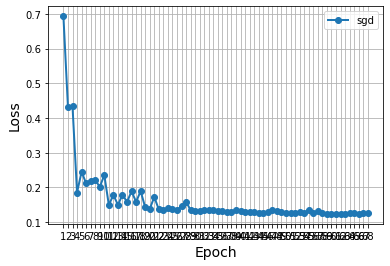

In [43]:
# plot the loss of your SGD classifier over time
### ACT 23
plotter('Loss', [loss_sgd], ['sgd'])

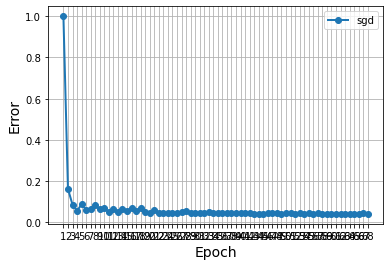

In [44]:
# plot the error of your SGD classifier over time
### ACT 24
plotter('Error', [error_sgd], ['sgd'])

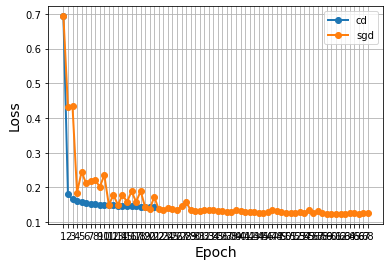

In [45]:
# plot the error of your SGD classifier and CD classifer on the same graph
### ACT 25
plotter('Loss', [loss, loss_sgd], ['cd', 'sgd'])

In [46]:
# this is similar to above
ind = (np.argwhere(((yte8 == 1) * (np.matmul(Xte, w_sgd) < 0))))[:,0]

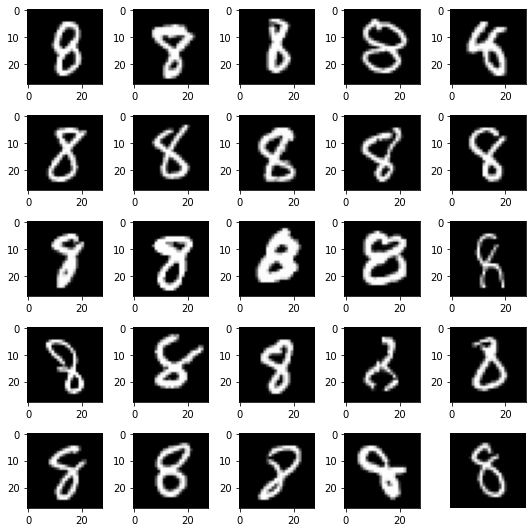

In [47]:
# Display 25 images of "8"s which your classifier incorrectly classified as non-8
ncols, nrows = 5, 5
fig, axes = plt.subplots(ncols, nrows, figsize=(1.5*ncols, 1.5*nrows))
for i in range(ncols * nrows):
    ax = axes[i//ncols, i%ncols]
    x = X_test[ind[i],:,:].reshape(28,28)
    plt.axis('off')
    plt.tight_layout()
    ax.imshow(x, cmap='gray')

### Classifying the digit 1
Now, repeat most of the above steps, except using the digit 1 instead. In particular:
- Obtain training and test labels (yte1 and ytr1) (Xtr and Xte should remain the same)
- Train a new weight vector using either CD or SGD
- Visualize your weight vector for "1"
- Plot the error of your weight vector for 1 over time
- Display images of "1"s which your classifier incorrectly classified as non-1

In [48]:
### ACT 26 (this may take multiple cells)

# obtain testing and training labels
ytr1 = (2 * (y_train == 1) - 1).reshape(len(y_train), 1)
yte1 = (2 * (y_test == 1) - 1).reshape(len(y_test), 1)

In [49]:
# train a new vector with SGD
epochs = 100
eta = 0.05
# eta_array = const_learning_rate(eta, epochs)  # use 0.01, 0.05 and 0.10
eta_array = decr_learning_rate(epochs)  # eta[t] = eta / sqrt(c + t), for eta=1 and c=10

start = time.time()
handle = prepare_logistic_sgd_handle(eta_array, epochs=epochs, batch_size=1000, eps=0.001)
[w_sgd_one, loss_sgd_one, error_sgd_one] = sgd(Xtr, ytr1, handle, verbose=False)
print('*** Elapsed time: {} minutes ***'.format(round(((time.time() - start) / 60.0), 2)))

*** Logistic Regression SGD Began ***

Epoch:  1  Loss: 0.038  Error: 1.268 %
Epoch:  2  Loss: 0.032  Error: 1.032 %
Epoch:  3  Loss: 0.032  Error: 1.008 %
Epoch:  4  Loss: 0.030  Error: 0.908 %
Epoch:  5  Loss: 0.029  Error: 0.885 %
Epoch:  6  Loss: 0.029  Error: 0.872 %
Epoch:  7  Loss: 0.028  Error: 0.853 %
Epoch:  8  Loss: 0.028  Error: 0.882 %
Epoch:  9  Loss: 0.027  Error: 0.832 %
Epoch: 10  Loss: 0.028  Error: 0.892 %
Epoch: 11  Loss: 0.027  Error: 0.808 %
Epoch: 12  Loss: 0.028  Error: 0.792 %
Epoch: 13  Loss: 0.027  Error: 0.795 %
Epoch: 14  Loss: 0.027  Error: 0.778 %
Epoch: 15  Loss: 0.026  Error: 0.827 %
Epoch: 16  Loss: 0.026  Error: 0.808 %
Epoch: 17  Loss: 0.027  Error: 0.855 %
Epoch: 18  Loss: 0.026  Error: 0.827 %
Epoch: 19  Loss: 0.026  Error: 0.807 %
Epoch: 20  Loss: 0.026  Error: 0.762 %
Epoch: 21  Loss: 0.026  Error: 0.742 %
Epoch: 22  Loss: 0.026  Error: 0.792 %
Epoch: 23  Loss: 0.026  Error: 0.743 %
Epoch: 24  Loss: 0.025  Error: 0.772 %
Epoch: 25  Loss: 0.025  E

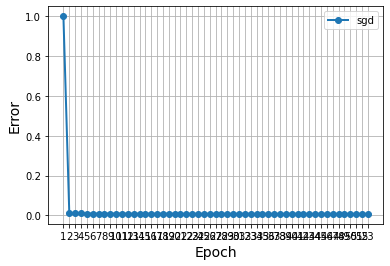

In [50]:
plotter('Error', [error_sgd_one], ['sgd'])

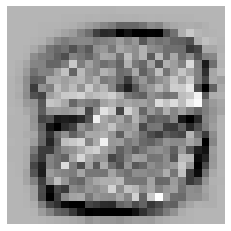

In [51]:
# visualize found weight vector

image_w = np.maximum(np.minimum(w_sgd, 3 * np.std(w_sgd_one)), -3 * np.std(w_sgd_one))
image_w = image_w[0:-1].reshape(28, 28)

plt.axis('off')
plt.imshow(image_w, cmap='gray')

In [52]:
# Visualize your weight vector for "1"
ind = (np.argwhere(((yte1 == 1) * (np.matmul(Xte, w) < 0))))[:,0]

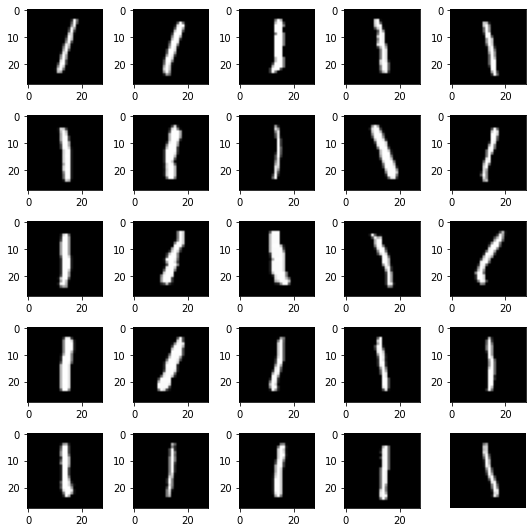

In [53]:
# Display 25 images of "1"s which your classifier incorrectly classified as non-1
# This kind of visualization can be useful if you're wondering what sorts of images give
#   your classifier trouble
ncols, nrows = 5, 5
fig, axes = plt.subplots(ncols, nrows, figsize=(1.5*ncols, 1.5*nrows))
for i in range(ncols * nrows):
    ax = axes[i//ncols, i%ncols]
    x = X_test[ind[i],:,:].reshape(28,28)
    plt.axis('off')
    plt.tight_layout()
    ax.imshow(x, cmap='gray')